In [1]:
### This trial notebook works to predict the ternary diagram for R32/R125/emimTF2N at 0.2 MPa, 298 K; added K values based on intuition

## To Update
# Change with AG's latest version of this notebook
# Update K values

In [2]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [3]:
from HFCS_emimTF2N_PR import configuration

In [4]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [5]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [6]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [29]:
# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [30]:
# m.fs.F101.initialize(outlvl=idaeslog.INFO_HIGH)

In [31]:
# result = solver.solve(m, tee=True)

In [32]:
# m.fs.F101.report()

In [37]:
IL_z = [0.001,0.4,0.72,0.91,0.99]
IL_x = np.zeros((len(IL_z)))
IL_y = np.zeros((len(IL_z)))
R32_x = np.zeros((len(IL_z)))
R32_y = np.zeros((len(IL_z)))
R125_x = np.zeros((len(IL_z)))
R125_y = np.zeros((len(IL_z))) 
Z = []

#Reset kappa values to check - these are the bmimpf6 values
# m.fs.props.PR_kappa['R32', 'R125'].fix(-0.002535)
# m.fs.props.PR_kappa['R125', 'R32'].fix(-0.002535)
# # m.fs.props.PR_kappa['R32', 'bmimPF6'].fix(-0.01435)
# # m.fs.props.PR_kappa['bmimPF6', 'R32'].fix(0.9651)
# # m.fs.props.PR_kappa['bmimPF6', 'R125'].fix(0.6312)
# # m.fs.props.PR_kappa['R125', 'bmimPF6'].fix(0.0504)

# m.fs.props.PR_kappa['R32', 'emimTf2N'].fix(-0.05102)
# m.fs.props.PR_kappa['emimTf2N', 'R32'].fix(0.2839)
# m.fs.props.PR_kappa['emimTf2N', 'R125'].fix(1.6929)
# m.fs.props.PR_kappa['R125', 'emimTf2N'].fix(0.04738)

# add in second for loop for pressure
# m.fs.F101.inlet.pressure.fix(200000)
for j in range(len(IL_z)):

    fract = 1 - IL_z[j] #Think about this
    m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*IL_z[j])
    m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.15)   
                  
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

    # solve the model
    status = solver.solve(m, tee = False)
    # model.display()
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        IL_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"])
        IL_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "emimTf2N"])
        R32_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

        #Change this to feasible
        print(value(m.fs.F101.liq_outlet.flow_mol[0]))
        print(value(m.fs.F101.vap_outlet.flow_mol[0]))
    else:
        print('Infeasible.')

    

0.1674389192036707
0.8325610807963293
0.17320448212889822
0.8267955178711017
0.17809162009087398
0.821908379909126
0.18111189003872136
0.8188881099612787
0.18241123042146992
0.8175887695785301


In [38]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [0.89584907 0.8660284  0.8422631  0.8282173  0.82231779]
IL_y = [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
R32_x = [0.00018588 0.0731341  0.12992806 0.16295278 0.17670613]
R32_y = [9.83563660e-04 3.95905443e-01 7.16455648e-01 9.08533540e-01
 9.89821347e-01]
R125_x = [0.10396505 0.0608375  0.02780884 0.00882992 0.00097608]
R125_y = [0.99901644 0.60409456 0.28354435 0.09146646 0.01017865]


In [39]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i], R32_x[i], R125_x[i])
    points_x.append(points)
    
print(points_x)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i], R32_y[i], R125_y[i])
    points_y.append(points)
    
print(points_y)

[(0.8958490696981966, 0.00018587778824029274, 0.10396505251356303), (0.8660283969347311, 0.07313410146916206, 0.060837501596106854), (0.8422630998778056, 0.1299280608260492, 0.02780883929614499), (0.8282172968750929, 0.1629527849467897, 0.008829918178093386), (0.8223177907034089, 0.1767061307057715, 0.000976078590819454)]
[(1e-08, 0.0009835636604527682, 0.9990164363395472), (1e-08, 0.39590544306760866, 0.6040945569323913), (1e-08, 0.71645564827716, 0.28354435172284), (1e-08, 0.9085335396631398, 0.09146646033683632), (1e-08, 0.9898213470961176, 0.010178652903882429)]


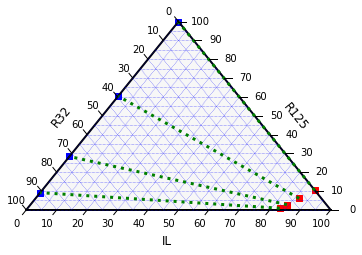

In [40]:
points_x = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_x[i]*100, R125_x[i]*100, R32_x[i]*100)
    points_x.append(points)

points_y = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_y[i]*100, R125_y[i]*100, R32_y[i]*100)
    points_y.append(points)

import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
# tax.set_title("Ternary phase diagram 8 bar\n", fontsize=24)
tax.left_axis_label("R32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("IL", fontsize=fontsize, offset=offset)

#for pressure changing plot would need to draw line between x[0] and x[final] for the indivual pressure
#use tax.line with the tax.scatter below
for i in range(4):
    tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")

# make this tax.line
tax.scatter(points_x, marker='s', color='red', label="liquid")
#Comment out for pressure changing plot
tax.scatter(points_y, marker='s', color='blue', label="vapor")


tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()